Plots 4 through 7, create a netcdf file for paraview to plot 3d init pic

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import simplesimdb as simplesim
from scipy import interpolate

import pandas as pd
plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)
FELTOR_PATH="../feltor" # path to the feltor library

In [2]:
with open ("guenter.json",'r') as f:
    params = json.load(f)
print(params)

{'equilibrium': 'guenter', 'description': 'square', 'I_0': 10.0, 'R_0': 3.0, 'comment': 'Sine functions; Guenter et al, J. Comput. Phys. 209 (2005) 354'}


In [3]:
# Here we use the Navier-Stokes program and feltordiag with zero timesteps to compute the toroidal averages
def create_inputfile() :
    with open ("guenter.json",'r') as f:
        params = json.load(f)
    inputfile = {}
    inputfile["magnetic_field"] = {
        "curvmode" : "toroidal",
        "input" : "params",
        "params" : params
    }

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"] = {
        "wall" : {"type" : "none" },
        "sheath" : {"type" : "none"},
        "bc" : {
            "density" : ["NEU", "NEU"],
            "velocity": ["NEU", "NEU"],
            "potential":["DIR", "DIR"],
            "aparallel":["NEU", "NEU"]
        }
    }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
                "type" : "blob", # secret init condition in Feltor
                "amplitude" : 4.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "sigma" : 0.05,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "exact-gaussian",
                "sigma_z" : 0.4
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "nu_parallel_n" : 0,
        "order" : 2
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-7,
        "atol" : 1e-10,
        "output-mode" : "Tend",
        "reject-limit"  : 2,
        "Tend" : 1e-4 # choose small we do not simulate anything
    }
    inputfile["FCI"] = {
        "periodify" : False,
        "refine" : [5,5],
        "interpolation-method" : "linear",
        "bc" : "along_field",
        "rk4eps" : 1e-6
    }
    inputfile["elliptic"] = {
        "stages" : 2,
        "eps_pol"    : [1e-6, 0.5],
        "eps_gamma" : 1e-7,
        "eps_ampere" : 1e-7,
        "direction" : "forward",
        "jumpfactor" : 1.0

    }
    inputfile["advection"]= {
        "type"  : "velocity-staggered",
        "slope-limiter" : "none"
    }
    inputfile["physical"] = {
        "mu" : -0.000272121,
        "epsilon_D" : 4.1458919332419e-05,
        "tau" : 1.0,
        "viscosity" : "value",
        "nu_parallel" : [0,0.1],
        "beta" : 1e-5,
        "resistivity" : 1e-4
    }
    inputfile["flags"] = []
    inputfile["output"] = {
        "type" : "netcdf",
        "inner_loop" : 1,
        "itstp" : 1,
        "maxout" : 0,
        "compression" : [1,1]
    }
    return inputfile


In [4]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "convoluted-toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
def plot( simfile, name, filename):
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')

    im = ax.pcolormesh(xc, yc, ncin[name][0,:,:],
                          vmin = 0.2, vmax = 0.4,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]")
    plt.savefig( filename,  bbox_inches = 'tight')
    plt.show()
    


In [6]:
simulator = simplesim.Manager( executable="./feltor.sh", directory="Averages/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="Averages/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="Averages/plot", filetype = "nc")


Existing simulation 38ae27...d45b4f.nc
Existing simulation 38ae27...d45b4f.nc
Averages/data/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


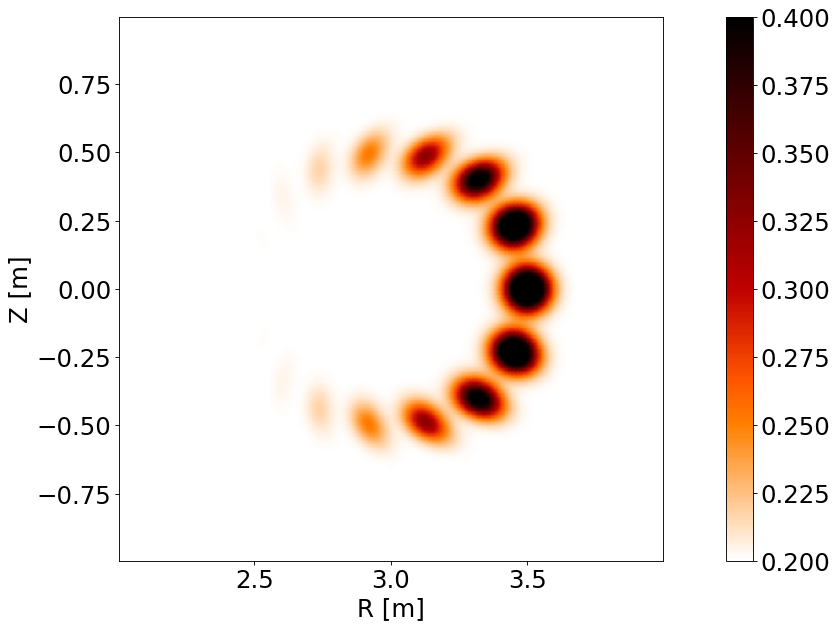

Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


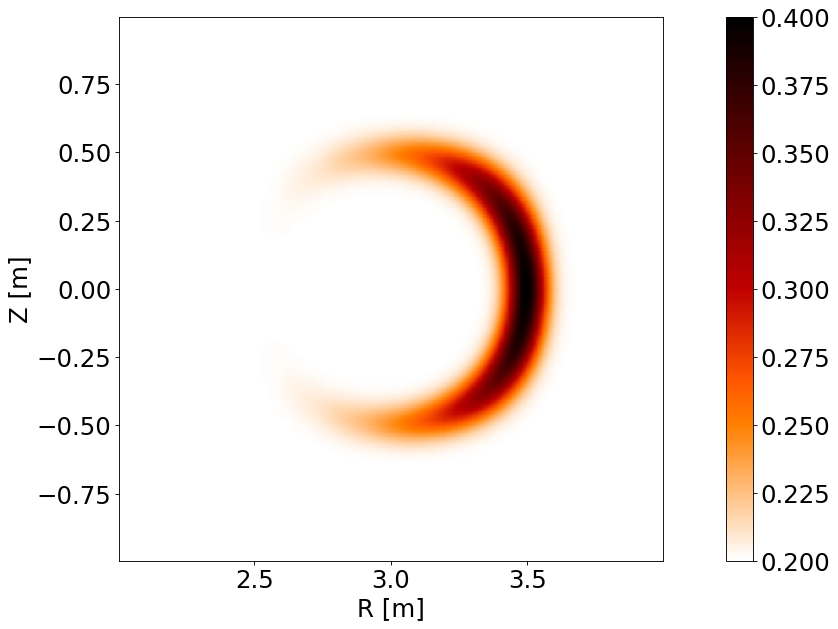

In [7]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile, error = "display")
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile,  "ions_ta2d", "init-cylinder-ta.png")
plot(diagfile, "ions_cta2d", "init-cylinder-cta10.png")

Existing simulation a907e5...3dbb06.nc
Existing simulation a907e5...3dbb06.nc
Averages/data/a907e5d53be2fd10d5031f046a90c0565a3dbb06.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


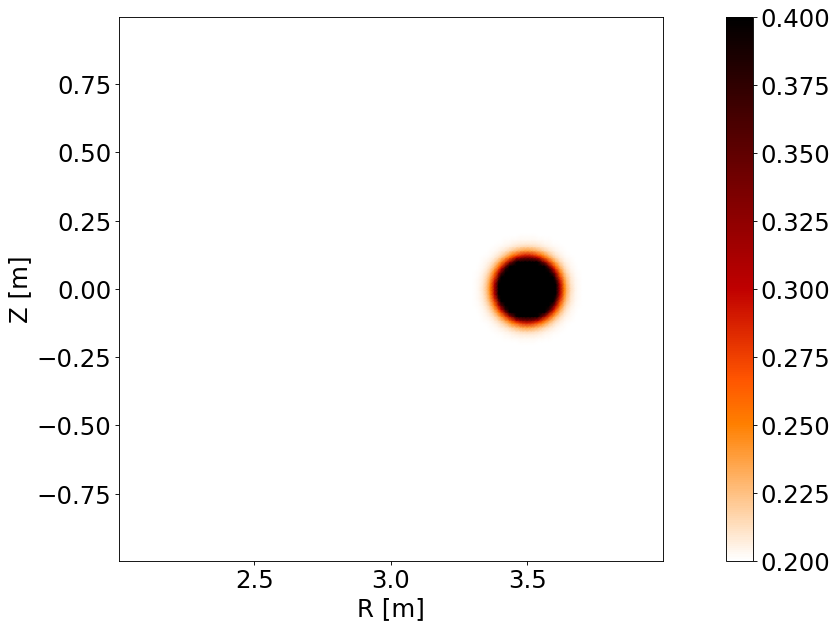

Averages/diag/a907e5d53be2fd10d5031f046a90c0565a3dbb06.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


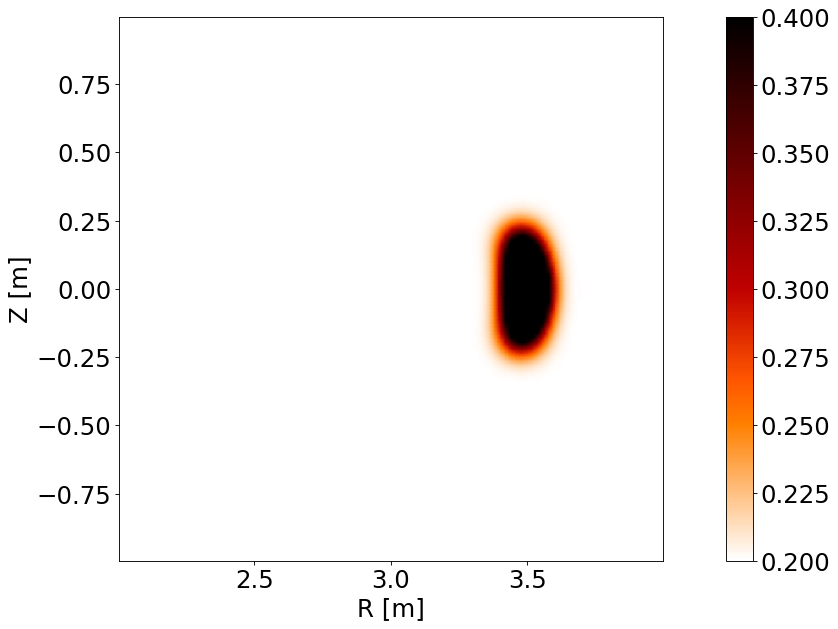

In [8]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"


simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile, "ions_ta2d", "init-toroidal-ta.png")
plot(diagfile, "ions_cta2d", "init-toroidal-cta10.png")

Existing simulation 38ae27...d45b4f.nc
Running simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


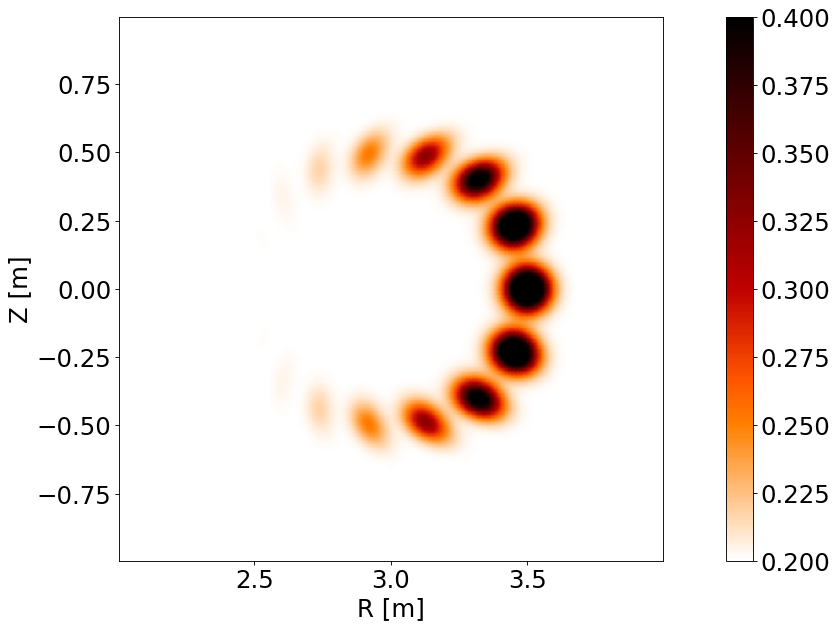

Running simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


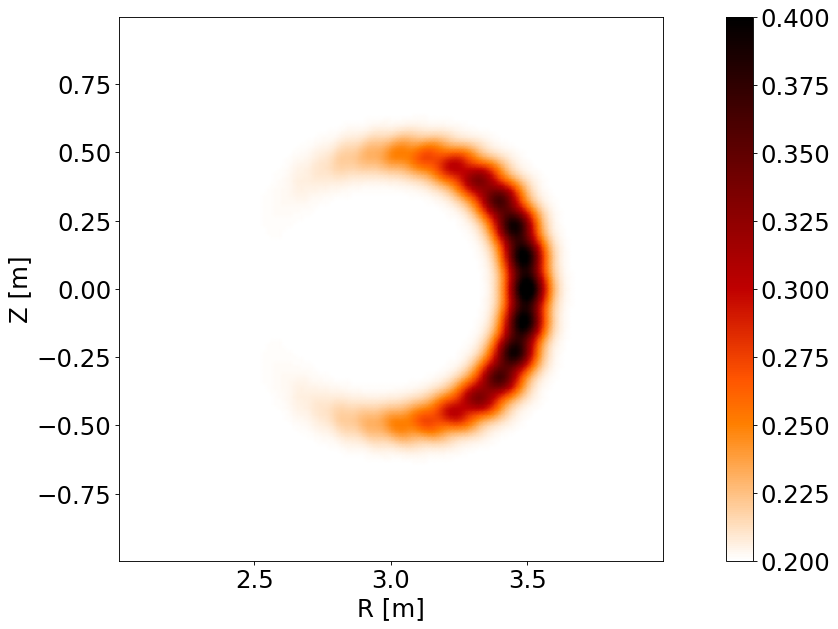

Running simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


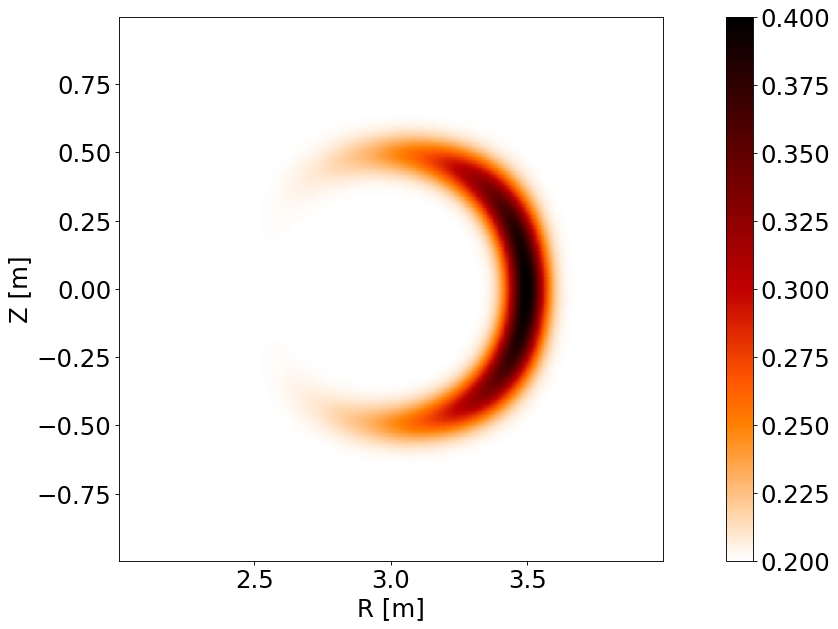

Running simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


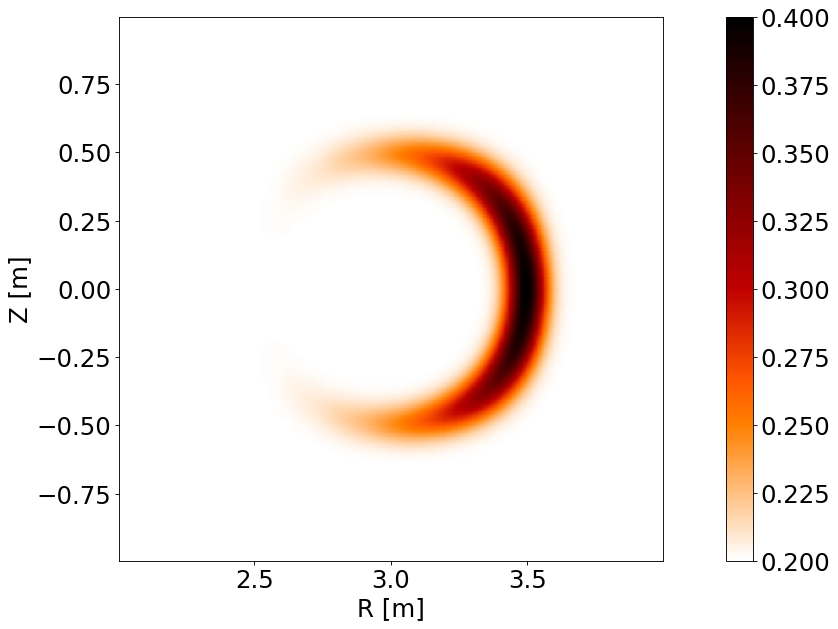

In [9]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10

simfile =  simulator.create( simulationfile)

config = create_default_config()
for Kphi in [1,2,5,10]:
    config["Kphi"] = Kphi
    with open( "config.json", 'w') as f:
        json.dump( config, f,
            sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.recreate( simulationfile) 

    plot(diagfile, "ions_cta2d", "init-cylinder-cta"+str(Kphi)+".png")

In [10]:
# let us generate a plot file to plot a nice 3d picture in paraview
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 200

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile, error="display")
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
print(plotfile)
# load plot_init_cylinder_3d statefile in paraview

Existing simulation 89f2d0...1b42c9.nc
Existing simulation 89f2d0...1b42c9.nc
Existing simulation 89f2d0...1b42c9.nc
Averages/plot/89f2d0c695868a8e6d7157c536c670af3b1b42c9.nc


In [11]:
print( "FILE CONTENTS")
ncin = Dataset( diagfile, 'r', format="NETCDF4")
for v in ncin.variables:
#     if v == "time" : 
#         print(f"{v} {ncin.variables[v].shape}")
#     else : 
    print( f"{v} {ncin.variables[v].shape}")
#     ,
#             f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
psi (192,)
eta (1920,)
dv2ddpsi (192,)
psi_vol2d (192,)
dvdpsi (192,)
psi_vol (192,)
psi_area (192,)
psi_arc (192,)
rho (192,)
rho_p (192,)
q-profile (192,)
psi_psi (192,)
psit1d (192,)
rho_t (192,)
xc (1920, 192)
yc (1920, 192)
vol (1920, 192)
time (1,)
y (150,)
x (150,)
electrons_cta2d (1, 150, 150)
electrons_cta2dX (1, 1920, 192)
electrons_fluc2d (1, 150, 150)
electrons_fsa (1, 192)
electrons_fsa2d (1, 150, 150)
electrons_ifs (1, 192)
electrons_ifs_lcfs (1,)
electrons_ifs_norm (1,)
electrons_std_fsa (1, 192)
ions_cta2d (1, 150, 150)
ions_cta2dX (1, 1920, 192)
ions_fluc2d (1, 150, 150)
ions_fsa (1, 192)
ions_fsa2d (1, 150, 150)
ions_ifs (1, 192)
ions_ifs_lcfs (1,)
ions_ifs_norm (1,)
ions_std_fsa (1, 192)
Ue_cta2d (1, 150, 150)
Ue_cta2dX (1, 1920, 192)
Ue_fluc2d (1, 150, 150)
Ue_fsa (1, 192)
Ue_fsa2d (1, 150, 150)
Ue_ifs (1, 192)
Ue_ifs_lcfs (1,)
Ue_ifs_norm (1,)
Ue_std_fsa (1, 192)
Ui_cta2d (1, 150, 150)
Ui_cta2dX (1, 1920, 192)
Ui_fluc2d (1, 150, 150)
Ui_fsa (1, 192)
U

leiperp_tt_cta2dX (1, 1920, 192)
leiperp_tt_fluc2d (1, 150, 150)
leiperp_tt_fsa (1, 192)
leiperp_tt_fsa2d (1, 150, 150)
leiperp_tt_ifs (1, 192)
leiperp_tt_ifs_lcfs (1,)
leiperp_tt_ifs_norm (1,)
leiperp_tt_std_fsa (1, 192)
leeparallel_tt_cta2d (1, 150, 150)
leeparallel_tt_cta2dX (1, 1920, 192)
leeparallel_tt_fluc2d (1, 150, 150)
leeparallel_tt_fsa (1, 192)
leeparallel_tt_fsa2d (1, 150, 150)
leeparallel_tt_ifs (1, 192)
leeparallel_tt_ifs_lcfs (1,)
leeparallel_tt_ifs_norm (1,)
leeparallel_tt_std_fsa (1, 192)
leiparallel_tt_cta2d (1, 150, 150)
leiparallel_tt_cta2dX (1, 1920, 192)
leiparallel_tt_fluc2d (1, 150, 150)
leiparallel_tt_fsa (1, 192)
leiparallel_tt_fsa2d (1, 150, 150)
leiparallel_tt_ifs (1, 192)
leiparallel_tt_ifs_lcfs (1,)
leiparallel_tt_ifs_norm (1,)
leiparallel_tt_std_fsa (1, 192)
divjeepar_tt_cta2d (1, 150, 150)
divjeepar_tt_cta2dX (1, 1920, 192)
divjeepar_tt_fluc2d (1, 150, 150)
divjeepar_tt_fsa (1, 192)
divjeepar_tt_fsa2d (1, 150, 150)
divjeepar_tt_ifs (1, 192)
divjeepar_tt_

In [12]:
# Construct the Gaussian weights on our grids
def gauss_weights( js) :
    n = js["n"]
    Nx = js["Nx"]
    Ny = js["Ny"]
    lx = 2
    ly = 2
    hx = lx/Nx
    hy = ly/Ny
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Nx"])
    weights1dY = np.tile( w, js["Ny"])
    return np.reshape( np.kron( weights1dY, weights1dX)*hy/2.0*hx/2.0 , (js["n"]*js["Ny"], js["n"]*js["Nx"]))

In [13]:
def compare_ta( simfile, bigfile, name1, name2) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    bigg = Dataset( bigfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    weights = gauss_weights( gg)

    num = ncin[name1][0,:,:]-0.2
    sol = bigg[name2][0,:,:]-0.2
    diff = num - sol
    norm_diff = np.sqrt(np.sum( diff[:,:]**2*weights ))
#     norm_diff = np.max(np.abs(diff))
    norm_sol = np.sqrt(np.sum( sol[:,:]**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    return norm_diff/ norm_sol

In [14]:
#define conversion function 
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x

def errorToString(x):
    return '%.2e' % x

In [15]:
# Create one big file
lines = list()
for Nphi in [5, 10, 20, 40,80] :
    simulationfile = create_inputfile()

    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 400
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
#     lines.append( [Nphi, compare_ta( simfile, bigdiag, "ions_ta2d", "ions_cta2d"),
#                   compare_ta( diagfile, bigdiag, "ions_cta2d", "ions_cta2d")])

df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^{ST}_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fieldaligned_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Existing simulation 9a4064...49dc30.nc
Existing simulation 9a4064...49dc30.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 38ae27...d45b4f.nc
Existing simulation 38ae27...d45b4f.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 4056e7...7544b9.nc
Existing simulation 4056e7...7544b9.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation c10ac9...c83487.nc
Existing simulation c10ac9...c83487.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 63fd84...7062d3.nc
Existing simulation 63fd84...7062d3.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc


/tmp/ipykernel_7825/3319939153.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}         \
                                                         error  order   
$N_\varphi$                                                             
5                                                     1.32e+00    n/a   
10                                                    6.20e-01   1.09   
20                                                    5.60e-02   3.47   
40                                                    1.06e-05  12.37   
80                                                    1.52e-07   6.12   

            $\langle f \rangle^{ST}_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                            error order  
$N_\varphi$                                                              
5                                                     7.06e-02      n/a  
10                                                    1.76e-02     2.01  
20                                                    4.40e-03     2.00  
40                                                    1.30e-03     1.76  
80                                                    6.88e-04     0.92

In [16]:
lines = list()
for Nphi in [5, 10, 20, 40,80] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 400
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
    #plot_ta(simfile)
df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^{ST}_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_toroidal_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Existing simulation 52d596...11a69e.nc
Existing simulation 52d596...11a69e.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation a907e5...3dbb06.nc
Existing simulation a907e5...3dbb06.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 481dd5...68cc31.nc
Existing simulation 481dd5...68cc31.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation ea5847...0dab92.nc
Existing simulation ea5847...0dab92.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation aa852d...ec2b6d.nc
Existing simulation aa852d...ec2b6d.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc


/tmp/ipykernel_7825/1498168959.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}        \
                                                         error order   
$N_\varphi$                                                            
5                                                     3.33e-03   n/a   
10                                                    9.02e-04  1.88   
20                                                    2.29e-04  1.98   
40                                                    5.71e-05  2.00   
80                                                    1.39e-05  2.04   

            $\langle f \rangle^{ST}_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                            error order  
$N_\varphi$                                                              
5                                                     7.66e-01      n/a  
10                                                    5.62e-01     0.45  
20                                                    2.83e-01     0.99  
40                                                    9.49e-02     1.58  
80                                                    2.59e-02     1.87

In [17]:
# Construct the Gaussian weights on our grids
def gauss_weights1d( js) :
    n = js["n"]
    Nx = js["Npsi"]
    lx = 1 # length drops out in relative error BUT NOT ABSOLUTE
    hx = lx/Nx
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Npsi"])*hx/2
    return weights1dX

In [18]:
def compare_fsa( simulationfile) :
    config = create_default_config()
    weights = gauss_weights1d( config)[:]
    config["fsa"] = "toroidal-average"
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile1 = diagnoser.recreate( simulationfile)
    ncin1 = Dataset( diagfile1, 'r', format="NETCDF4")
    num = ncin1["ions_fsa"][:]
    norm = np.sqrt(np.sum( num[:]**2*weights ))
    print(norm)
    ncin1.close()

    config["fsa"] = "convoluted-toroidal-average"
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile2 = diagnoser.recreate( simulationfile)
    ncin2 = Dataset( diagfile2, 'r', format="NETCDF4")  
    sol = ncin2["ions_fsa"][:]
    norm = np.sqrt(np.sum( sol[:]**2*weights ))
    print(norm)
    ncin2.close()
    

    diff = num - sol
    #norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff[:]**2*weights ))
    #norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( num[:]**2*weights ))

    return norm_diff/ norm_sol

In [ ]:
# Here, we create a comparison between the fsa and fsa(smooth)
linesT = list()
for Nphi in [5,10,20,40] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    print(simfile)
    linesT.append( [Nphi, compare_fsa( simulationfile)])
    #plot_ta(simfile)

Existing simulation 52d596...11a69e.nc
Averages/data/52d5962287daffc17436fc6f1990627d2611a69e.nc
Running simulation 52d596...11a69e.nc
0.21184592514929268
Running simulation 52d596...11a69e.nc
0.2116243403610298
Existing simulation a907e5...3dbb06.nc
Averages/data/a907e5d53be2fd10d5031f046a90c0565a3dbb06.nc
Running simulation a907e5...3dbb06.nc
0.21181437996039862
Running simulation a907e5...3dbb06.nc


In [ ]:
df = pd.DataFrame(linesT, columns=["$N_\\varphi$", "error.fsa"])
name = "fsa"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f - S(f) \rangle/\langle f\rangle$ "  ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fsa_smooth_toroidal.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

In [ ]:
# Here, we create a comparison between the fsa and fsa(smooth)
linesE = list()
for Nphi in [5,10,20,40] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    print(simfile)
    linesE.append( [Nphi, compare_fsa( simulationfile)])
    #plot_ta(simfile)

In [ ]:
df = pd.DataFrame(linesE, columns=["$N_\\varphi$", "error.fsa"])
name = "fsa"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
    np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f - S(f)\rangle$ "  ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fsa_smooth_aligned.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

In [ ]:
# Here, we create a comparison between the volume integration
# We try to produce the integral of the full square and an integral of only 6/7% to avoid X-points
# The first volume is given analytically but the second has to be computed numerically
lines = list()
#for Nphi in [5]:#,10,20,40,80] :
simulationfile = create_inputfile()
simulationfile["grid"]["Nx"] =50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 5
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal"
simfile =  simulator.create( simulationfile)
npsi = 3
for Npsi in [8,16,32,64,128] : 
    Neta = 10*Npsi
    config = create_default_config()
    config["fsa"] = "toroidal-average" # important because cta is not good for toroidal gaussian

    config["n"] = npsi
    config["Npsi"] = Npsi
    config["Neta"] = Neta
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.recreate( simulationfile)

    ncin = Dataset( diagfile, 'r', format="NETCDF4")
    num = ncin["ions_ifs_lcfs"][0]
    ## Let us create the volume integral for 6/7 Psi value
    (x,w) = np.polynomial.legendre.leggauss(npsi)
    hpsi = 1./(Npsi-int(Npsi/8))
    v1d = np.tile( w, Npsi-int(2*Npsi/8))*hpsi/2.0*ncin["dvdpsi"][npsi*int(2*Npsi/8):npsi*Npsi]
#     test = ncin["ions_fsa"][0,npsi*int(Npsi/8):npsi*Npsi]
    num_fsa = -np.sum(v1d)
    ana_fsa = 56.466538178583720300 # Mathematica value
    print( num_fsa, ana_fsa, (num_fsa - ana_fsa)/ana_fsa)
    
    vol = 2*np.pi*ncin["vol"][:,npsi*int(Npsi/8):npsi*Npsi]*ncin["xc"][:,npsi*int(Npsi/8):npsi*Npsi]
    volumeX = np.sum( vol)
    print( "Npsi",Npsi,"Volume error in X-grid",  (volumeX-24*np.pi)/(24*np.pi))
    ncin.close()
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    num_ana = np.sum(ncin["ions"][0,:,:,:]*ncin["vol3d"][:,:,:])
    #print( (np.pi*(3+1)**2 - np.pi*(3-1)**2)*2)
    ana = 0.2*24*np.pi+0.6841011042693754
    print( num, ana, num_ana, (num - num_ana )/ num_ana)

    lines.append( [npsi*Npsi, np.abs(num - num_ana)/num_ana, np.abs(num_fsa - ana_fsa)/ana_fsa ])
    #plot_ta(simfile)


In [ ]:
df = pd.DataFrame(lines[1:], columns=["$N_\\psi$", "error.ifs", "error.vol"])
for name  in ["ifs", "vol"] :
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])

    df["order."+name] = (np.log( df["order."+name]/ df["order."+name].shift(1))/
     np.log( df["$N_\\psi$"].shift(1)/df["$N_\\psi$"]))
df.set_index(['$N_\\psi$'], inplace=True) 
headers = [ "$\\frac{|\int  f dV - \int  \langle f\rangle dv|}{\int  \langle f\rangle dv}$",
           "$\\frac{|\int dV - \int dv |}{\int dv}$ (excl. X-point)"]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_ifs.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

In [ ]:
# Here, we create a comparison of area and arc length computation
lines2 = list()
#for Nphi in [5]:#,10,20,40,80] :
simulationfile = create_inputfile()
with open ("circular.json", 'r') as f :
    params = json.load(f)
simulationfile["magnetic_field"]["params"] = params
simulationfile["magnetic_field"]["params"]["a"] = 1.5
simulationfile["magnetic_field"]["params"]["b"] = 0.75
# simulationfile["magnetic_field"]["params"]["a"] = 1.0
# simulationfile["magnetic_field"]["params"]["b"] = 1.0
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 5
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal"
simfile =  simulator.create( simulationfile)
npsi = 3
for Npsi in [2,4,8,16,32] : 
    Neta = 10*Npsi
    config = create_default_config()
    config["fsa"] = "toroidal-average" # important because cta is not good for toroidal gaussian

    config["n"] = npsi
    config["Npsi"] = Npsi
    config["Neta"] = Neta
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.recreate( simulationfile)

    ncin = Dataset( diagfile, 'r', format="NETCDF4")
    arclength = ncin["psi_arc"][:]
    area = ncin["psi_vol2d"][:]
    psi_psi = ncin["psi_psi"][:]
    areainterp = interpolate.interp1d( psi_psi, area, "cubic")
    arcinterp = interpolate.interp1d( psi_psi, arclength, "cubic")
#     print( areainterp(1))
    area0d = areainterp( 0)# - areainterp(0.75)
    arclength0d = arcinterp( 0)
    area0d_ana = 9/8*np.pi
#     area0d_ana = np.pi - np.pi*0.5**2
    arclength0d_ana = 7.26633616541076
#     arclength0d_ana = 2.0*np.pi
    print("Npsi", Npsi, "Arclength error ", (arclength0d-arclength0d_ana)/arclength0d_ana)
    print("Npsi", Npsi,  "Area error ", (area0d-area0d_ana)/area0d_ana)

    ncin.close()
    lines2.append( [npsi*Npsi, np.abs(arclength0d-arclength0d_ana)/arclength0d_ana, np.abs(area0d-area0d_ana)/area0d_ana])
    #plot_ta(simfile)


In [ ]:
df = pd.DataFrame(lines2[:], columns=["$N_\\psi$", "error.arc", "error.area"])
for name  in ["arc", "area"] :
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])

    df["order."+name] = (np.log( df["order."+name]/ df["order."+name].shift(1))/
     np.log( df["$N_\\psi$"].shift(1)/df["$N_\\psi$"]))
df.set_index(['$N_\\psi$'], inplace=True) 
headers = [ "$\int_{\text{ellipse}} ds$", "$\int_{\text{ellipse}} dA$"]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_arc.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df